# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-keras-model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

  196608/11490434 [..............................] - ETA: 3s

 2818048/11490434 [======>.......................] - ETA: 0s

 6086656/11490434 [==============>...............] - ETA: 0s

10846208/11490434 [===========================>..] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 50:45 - loss: 0.6934

  17/1875 [..............................] - ETA: 5s - loss: 0.6032   

  35/1875 [..............................] - ETA: 5s - loss: 0.5222

  57/1875 [..............................] - ETA: 4s - loss: 0.4666

  73/1875 [>.............................] - ETA: 5s - loss: 0.4405

  94/1875 [>.............................] - ETA: 4s - loss: 0.4156

 114/1875 [>.............................] - ETA: 4s - loss: 0.3978

 135/1875 [=>............................] - ETA: 4s - loss: 0.3829

 154/1875 [=>............................] - ETA: 4s - loss: 0.3717

 174/1875 [=>............................] - ETA: 4s - loss: 0.3616

 191/1875 [==>...........................] - ETA: 4s - loss: 0.3541

 213/1875 [==>...........................] - ETA: 4s - loss: 0.3454

 234/1875 [==>...........................] - ETA: 4s - loss: 0.3381

 254/1875 [===>..........................] - ETA: 4s - loss: 0.3319

 272/1875 [===>..........................] - ETA: 4s - loss: 0.3267

 284/1875 [===>..........................] - ETA: 4s - loss: 0.3234

 308/1875 [===>..........................] - ETA: 4s - loss: 0.3174

 321/1875 [====>.........................] - ETA: 4s - loss: 0.3144

 336/1875 [====>.........................] - ETA: 4s - loss: 0.3110

 352/1875 [====>.........................] - ETA: 4s - loss: 0.3077

 371/1875 [====>.........................] - ETA: 4s - loss: 0.3039

 391/1875 [=====>........................] - ETA: 4s - loss: 0.3001

 410/1875 [=====>........................] - ETA: 4s - loss: 0.2968

 422/1875 [=====>........................] - ETA: 4s - loss: 0.2947

 444/1875 [======>.......................] - ETA: 4s - loss: 0.2911

 463/1875 [======>.......................] - ETA: 4s - loss: 0.2882

 479/1875 [======>.......................] - ETA: 4s - loss: 0.2859

 501/1875 [=======>......................] - ETA: 3s - loss: 0.2828

 524/1875 [=======>......................] - ETA: 3s - loss: 0.2797

 545/1875 [=======>......................] - ETA: 3s - loss: 0.2771

 562/1875 [=======>......................] - ETA: 3s - loss: 0.2750

 580/1875 [========>.....................] - ETA: 3s - loss: 0.2729

 592/1875 [========>.....................] - ETA: 3s - loss: 0.2715

 607/1875 [========>.....................] - ETA: 3s - loss: 0.2698

 619/1875 [========>.....................] - ETA: 3s - loss: 0.2685

 637/1875 [=========>....................] - ETA: 3s - loss: 0.2666

 648/1875 [=========>....................] - ETA: 3s - loss: 0.2655

 662/1875 [=========>....................] - ETA: 3s - loss: 0.2641

 673/1875 [=========>....................] - ETA: 3s - loss: 0.2630

 687/1875 [=========>....................] - ETA: 3s - loss: 0.2617

 700/1875 [==========>...................] - ETA: 3s - loss: 0.2604

 718/1875 [==========>...................] - ETA: 3s - loss: 0.2588

 731/1875 [==========>...................] - ETA: 3s - loss: 0.2576

 741/1875 [==========>...................] - ETA: 3s - loss: 0.2567

 757/1875 [===========>..................] - ETA: 3s - loss: 0.2554

 771/1875 [===========>..................] - ETA: 3s - loss: 0.2542

 788/1875 [===========>..................] - ETA: 3s - loss: 0.2528

 800/1875 [===========>..................] - ETA: 3s - loss: 0.2518

 815/1875 [============>.................] - ETA: 3s - loss: 0.2507

 826/1875 [============>.................] - ETA: 3s - loss: 0.2498

 834/1875 [============>.................] - ETA: 3s - loss: 0.2492

 844/1875 [============>.................] - ETA: 3s - loss: 0.2485

 859/1875 [============>.................] - ETA: 3s - loss: 0.2474

 872/1875 [============>.................] - ETA: 3s - loss: 0.2464

 886/1875 [=============>................] - ETA: 3s - loss: 0.2454

 893/1875 [=============>................] - ETA: 3s - loss: 0.2449

 903/1875 [=============>................] - ETA: 3s - loss: 0.2443

 930/1875 [=============>................] - ETA: 3s - loss: 0.2424

 943/1875 [==============>...............] - ETA: 3s - loss: 0.2416

 964/1875 [==============>...............] - ETA: 2s - loss: 0.2402

 981/1875 [==============>...............] - ETA: 2s - loss: 0.2392

 996/1875 [==============>...............] - ETA: 2s - loss: 0.2382

1015/1875 [===============>..............] - ETA: 2s - loss: 0.2371

1033/1875 [===============>..............] - ETA: 2s - loss: 0.2360

1055/1875 [===============>..............] - ETA: 2s - loss: 0.2348

1074/1875 [================>.............] - ETA: 2s - loss: 0.2337

1096/1875 [================>.............] - ETA: 2s - loss: 0.2325

1113/1875 [================>.............] - ETA: 2s - loss: 0.2316

1133/1875 [=================>............] - ETA: 2s - loss: 0.2305

1151/1875 [=================>............] - ETA: 2s - loss: 0.2296

1173/1875 [=================>............] - ETA: 2s - loss: 0.2284

1192/1875 [==================>...........] - ETA: 2s - loss: 0.2275

1210/1875 [==================>...........] - ETA: 2s - loss: 0.2266

1232/1875 [==================>...........] - ETA: 1s - loss: 0.2256

1253/1875 [===================>..........] - ETA: 1s - loss: 0.2246

1273/1875 [===================>..........] - ETA: 1s - loss: 0.2237

1296/1875 [===================>..........] - ETA: 1s - loss: 0.2226

1322/1875 [====================>.........] - ETA: 1s - loss: 0.2215

1345/1875 [====================>.........] - ETA: 1s - loss: 0.2205

1372/1875 [====================>.........] - ETA: 1s - loss: 0.2194

1396/1875 [=====================>........] - ETA: 1s - loss: 0.2184

1417/1875 [=====================>........] - ETA: 1s - loss: 0.2175

1446/1875 [======================>.......] - ETA: 1s - loss: 0.2164

1468/1875 [======================>.......] - ETA: 1s - loss: 0.2155

1486/1875 [======================>.......] - ETA: 1s - loss: 0.2149

1508/1875 [=======================>......] - ETA: 1s - loss: 0.2140

1529/1875 [=======================>......] - ETA: 1s - loss: 0.2133

1553/1875 [=======================>......] - ETA: 0s - loss: 0.2124

1577/1875 [========================>.....] - ETA: 0s - loss: 0.2116

1601/1875 [========================>.....] - ETA: 0s - loss: 0.2107

1625/1875 [=========================>....] - ETA: 0s - loss: 0.2099

1650/1875 [=========================>....] - ETA: 0s - loss: 0.2091

1673/1875 [=========================>....] - ETA: 0s - loss: 0.2083

1693/1875 [==========================>...] - ETA: 0s - loss: 0.2077

1714/1875 [==========================>...] - ETA: 0s - loss: 0.2070

1735/1875 [==========================>...] - ETA: 0s - loss: 0.2063

1754/1875 [===========================>..] - ETA: 0s - loss: 0.2058

1773/1875 [===========================>..] - ETA: 0s - loss: 0.2052

1799/1875 [===========================>..] - ETA: 0s - loss: 0.2044

1827/1875 [============================>.] - ETA: 0s - loss: 0.2036

1851/1875 [============================>.] - ETA: 0s - loss: 0.2029

1863/1875 [============================>.] - ETA: 0s - loss: 0.2025

1875/1875 [==============================] - 7s 3ms/step - loss: 0.2022


Epoch 2/5


   1/1875 [..............................] - ETA: 8s - loss: 0.1174

  20/1875 [..............................] - ETA: 4s - loss: 0.1108

  38/1875 [..............................] - ETA: 5s - loss: 0.1107

  57/1875 [..............................] - ETA: 5s - loss: 0.1104

  74/1875 [>.............................] - ETA: 5s - loss: 0.1101

  93/1875 [>.............................] - ETA: 5s - loss: 0.1099

 109/1875 [>.............................] - ETA: 5s - loss: 0.1097

 125/1875 [=>............................] - ETA: 5s - loss: 0.1096

 145/1875 [=>............................] - ETA: 5s - loss: 0.1095

 164/1875 [=>............................] - ETA: 5s - loss: 0.1093

 178/1875 [=>............................] - ETA: 5s - loss: 0.1092

 195/1875 [==>...........................] - ETA: 5s - loss: 0.1092

 210/1875 [==>...........................] - ETA: 5s - loss: 0.1091

 234/1875 [==>...........................] - ETA: 4s - loss: 0.1090

 246/1875 [==>...........................] - ETA: 4s - loss: 0.1089

 263/1875 [===>..........................] - ETA: 4s - loss: 0.1088

 277/1875 [===>..........................] - ETA: 4s - loss: 0.1088

 295/1875 [===>..........................] - ETA: 4s - loss: 0.1087

 311/1875 [===>..........................] - ETA: 4s - loss: 0.1087

 329/1875 [====>.........................] - ETA: 4s - loss: 0.1086

 344/1875 [====>.........................] - ETA: 4s - loss: 0.1085

 362/1875 [====>.........................] - ETA: 4s - loss: 0.1085

 377/1875 [=====>........................] - ETA: 4s - loss: 0.1084

 396/1875 [=====>........................] - ETA: 4s - loss: 0.1084

 411/1875 [=====>........................] - ETA: 4s - loss: 0.1083

 430/1875 [=====>........................] - ETA: 4s - loss: 0.1083

 449/1875 [======>.......................] - ETA: 4s - loss: 0.1082

 463/1875 [======>.......................] - ETA: 4s - loss: 0.1082

 479/1875 [======>.......................] - ETA: 4s - loss: 0.1081

 497/1875 [======>.......................] - ETA: 4s - loss: 0.1081

 520/1875 [=======>......................] - ETA: 4s - loss: 0.1080

 537/1875 [=======>......................] - ETA: 4s - loss: 0.1080

 558/1875 [=======>......................] - ETA: 4s - loss: 0.1079

 578/1875 [========>.....................] - ETA: 3s - loss: 0.1079

 597/1875 [========>.....................] - ETA: 3s - loss: 0.1078

 618/1875 [========>.....................] - ETA: 3s - loss: 0.1078

 639/1875 [=========>....................] - ETA: 3s - loss: 0.1077

 659/1875 [=========>....................] - ETA: 3s - loss: 0.1077

 681/1875 [=========>....................] - ETA: 3s - loss: 0.1076

 699/1875 [==========>...................] - ETA: 3s - loss: 0.1076

 714/1875 [==========>...................] - ETA: 3s - loss: 0.1075

 728/1875 [==========>...................] - ETA: 3s - loss: 0.1075

 747/1875 [==========>...................] - ETA: 3s - loss: 0.1074

 768/1875 [===========>..................] - ETA: 3s - loss: 0.1074

 785/1875 [===========>..................] - ETA: 3s - loss: 0.1074

 810/1875 [===========>..................] - ETA: 3s - loss: 0.1073

 827/1875 [============>.................] - ETA: 3s - loss: 0.1073

 848/1875 [============>.................] - ETA: 3s - loss: 0.1072

 868/1875 [============>.................] - ETA: 2s - loss: 0.1072

 885/1875 [=============>................] - ETA: 2s - loss: 0.1071

 906/1875 [=============>................] - ETA: 2s - loss: 0.1071

 925/1875 [=============>................] - ETA: 2s - loss: 0.1070

 943/1875 [==============>...............] - ETA: 2s - loss: 0.1070

 966/1875 [==============>...............] - ETA: 2s - loss: 0.1070

 986/1875 [==============>...............] - ETA: 2s - loss: 0.1069

1004/1875 [===============>..............] - ETA: 2s - loss: 0.1069

1025/1875 [===============>..............] - ETA: 2s - loss: 0.1068

1045/1875 [===============>..............] - ETA: 2s - loss: 0.1068

1061/1875 [===============>..............] - ETA: 2s - loss: 0.1068

1078/1875 [================>.............] - ETA: 2s - loss: 0.1067

1094/1875 [================>.............] - ETA: 2s - loss: 0.1067

1111/1875 [================>.............] - ETA: 2s - loss: 0.1066

1126/1875 [=================>............] - ETA: 2s - loss: 0.1066

1138/1875 [=================>............] - ETA: 2s - loss: 0.1066

1148/1875 [=================>............] - ETA: 2s - loss: 0.1066

1161/1875 [=================>............] - ETA: 2s - loss: 0.1065

1173/1875 [=================>............] - ETA: 2s - loss: 0.1065

1186/1875 [=================>............] - ETA: 2s - loss: 0.1065

1196/1875 [==================>...........] - ETA: 2s - loss: 0.1065

1210/1875 [==================>...........] - ETA: 1s - loss: 0.1064

1222/1875 [==================>...........] - ETA: 1s - loss: 0.1064

1229/1875 [==================>...........] - ETA: 1s - loss: 0.1064

1239/1875 [==================>...........] - ETA: 1s - loss: 0.1064

1248/1875 [==================>...........] - ETA: 1s - loss: 0.1064

1266/1875 [===================>..........] - ETA: 1s - loss: 0.1063

1282/1875 [===================>..........] - ETA: 1s - loss: 0.1063

1302/1875 [===================>..........] - ETA: 1s - loss: 0.1063

1318/1875 [====================>.........] - ETA: 1s - loss: 0.1062

1330/1875 [====================>.........] - ETA: 1s - loss: 0.1062

1344/1875 [====================>.........] - ETA: 1s - loss: 0.1062

1361/1875 [====================>.........] - ETA: 1s - loss: 0.1062

1373/1875 [====================>.........] - ETA: 1s - loss: 0.1061

1388/1875 [=====================>........] - ETA: 1s - loss: 0.1061

1401/1875 [=====================>........] - ETA: 1s - loss: 0.1061

1412/1875 [=====================>........] - ETA: 1s - loss: 0.1061

1424/1875 [=====================>........] - ETA: 1s - loss: 0.1060

1439/1875 [======================>.......] - ETA: 1s - loss: 0.1060

1454/1875 [======================>.......] - ETA: 1s - loss: 0.1060

1470/1875 [======================>.......] - ETA: 1s - loss: 0.1060

1490/1875 [======================>.......] - ETA: 1s - loss: 0.1059

1504/1875 [=======================>......] - ETA: 1s - loss: 0.1059

1525/1875 [=======================>......] - ETA: 1s - loss: 0.1059

1537/1875 [=======================>......] - ETA: 1s - loss: 0.1058

1552/1875 [=======================>......] - ETA: 1s - loss: 0.1058

1568/1875 [========================>.....] - ETA: 0s - loss: 0.1058

1582/1875 [========================>.....] - ETA: 0s - loss: 0.1058

1596/1875 [========================>.....] - ETA: 0s - loss: 0.1057

1616/1875 [========================>.....] - ETA: 0s - loss: 0.1057

1633/1875 [=========================>....] - ETA: 0s - loss: 0.1057

1648/1875 [=========================>....] - ETA: 0s - loss: 0.1057

1666/1875 [=========================>....] - ETA: 0s - loss: 0.1056

1686/1875 [=========================>....] - ETA: 0s - loss: 0.1056

1707/1875 [==========================>...] - ETA: 0s - loss: 0.1056

1729/1875 [==========================>...] - ETA: 0s - loss: 0.1055

1745/1875 [==========================>...] - ETA: 0s - loss: 0.1055

1763/1875 [===========================>..] - ETA: 0s - loss: 0.1055

1785/1875 [===========================>..] - ETA: 0s - loss: 0.1054

1806/1875 [===========================>..] - ETA: 0s - loss: 0.1054

1821/1875 [============================>.] - ETA: 0s - loss: 0.1054

1839/1875 [============================>.] - ETA: 0s - loss: 0.1054

1856/1875 [============================>.] - ETA: 0s - loss: 0.1053

1874/1875 [============================>.] - ETA: 0s - loss: 0.1053

1875/1875 [==============================] - 6s 3ms/step - loss: 0.1053


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0893

  16/1875 [..............................] - ETA: 7s - loss: 0.0970

  38/1875 [..............................] - ETA: 5s - loss: 0.0980

  58/1875 [..............................] - ETA: 5s - loss: 0.0981

  78/1875 [>.............................] - ETA: 5s - loss: 0.0981

  95/1875 [>.............................] - ETA: 5s - loss: 0.0981

 114/1875 [>.............................] - ETA: 5s - loss: 0.0982

 132/1875 [=>............................] - ETA: 5s - loss: 0.0982

 153/1875 [=>............................] - ETA: 4s - loss: 0.0982

 168/1875 [=>............................] - ETA: 4s - loss: 0.0982

 184/1875 [=>............................] - ETA: 4s - loss: 0.0982

 200/1875 [==>...........................] - ETA: 4s - loss: 0.0981

 217/1875 [==>...........................] - ETA: 4s - loss: 0.0981

 237/1875 [==>...........................] - ETA: 4s - loss: 0.0981

 250/1875 [===>..........................] - ETA: 4s - loss: 0.0981

 268/1875 [===>..........................] - ETA: 4s - loss: 0.0980

 286/1875 [===>..........................] - ETA: 4s - loss: 0.0980

 303/1875 [===>..........................] - ETA: 4s - loss: 0.0980

 314/1875 [====>.........................] - ETA: 4s - loss: 0.0980

 328/1875 [====>.........................] - ETA: 4s - loss: 0.0980

 341/1875 [====>.........................] - ETA: 4s - loss: 0.0979

 352/1875 [====>.........................] - ETA: 4s - loss: 0.0979

 368/1875 [====>.........................] - ETA: 4s - loss: 0.0979

 382/1875 [=====>........................] - ETA: 4s - loss: 0.0979

 395/1875 [=====>........................] - ETA: 4s - loss: 0.0979

 406/1875 [=====>........................] - ETA: 4s - loss: 0.0979

 423/1875 [=====>........................] - ETA: 4s - loss: 0.0979

 440/1875 [======>.......................] - ETA: 4s - loss: 0.0979

 457/1875 [======>.......................] - ETA: 4s - loss: 0.0979

 471/1875 [======>.......................] - ETA: 4s - loss: 0.0979

 485/1875 [======>.......................] - ETA: 4s - loss: 0.0979

 496/1875 [======>.......................] - ETA: 4s - loss: 0.0979

 510/1875 [=======>......................] - ETA: 4s - loss: 0.0979

 527/1875 [=======>......................] - ETA: 4s - loss: 0.0978

 539/1875 [=======>......................] - ETA: 4s - loss: 0.0978

 556/1875 [=======>......................] - ETA: 4s - loss: 0.0978

 567/1875 [========>.....................] - ETA: 4s - loss: 0.0978

 584/1875 [========>.....................] - ETA: 4s - loss: 0.0978

 602/1875 [========>.....................] - ETA: 4s - loss: 0.0978

 617/1875 [========>.....................] - ETA: 4s - loss: 0.0978

 633/1875 [=========>....................] - ETA: 4s - loss: 0.0978

 644/1875 [=========>....................] - ETA: 4s - loss: 0.0978

 658/1875 [=========>....................] - ETA: 4s - loss: 0.0978

 673/1875 [=========>....................] - ETA: 4s - loss: 0.0978

 685/1875 [=========>....................] - ETA: 4s - loss: 0.0978

 700/1875 [==========>...................] - ETA: 3s - loss: 0.0978

 712/1875 [==========>...................] - ETA: 3s - loss: 0.0978

 724/1875 [==========>...................] - ETA: 3s - loss: 0.0978

 737/1875 [==========>...................] - ETA: 3s - loss: 0.0978

 750/1875 [===========>..................] - ETA: 3s - loss: 0.0978

 765/1875 [===========>..................] - ETA: 3s - loss: 0.0977

 780/1875 [===========>..................] - ETA: 3s - loss: 0.0977

 792/1875 [===========>..................] - ETA: 3s - loss: 0.0977

 816/1875 [============>.................] - ETA: 3s - loss: 0.0977

 836/1875 [============>.................] - ETA: 3s - loss: 0.0977

 853/1875 [============>.................] - ETA: 3s - loss: 0.0977

 877/1875 [=============>................] - ETA: 3s - loss: 0.0977

 896/1875 [=============>................] - ETA: 3s - loss: 0.0977

 917/1875 [=============>................] - ETA: 3s - loss: 0.0977

 935/1875 [=============>................] - ETA: 3s - loss: 0.0977

 953/1875 [==============>...............] - ETA: 3s - loss: 0.0977

 967/1875 [==============>...............] - ETA: 3s - loss: 0.0977

 986/1875 [==============>...............] - ETA: 2s - loss: 0.0977

1004/1875 [===============>..............] - ETA: 2s - loss: 0.0977

1022/1875 [===============>..............] - ETA: 2s - loss: 0.0977

1039/1875 [===============>..............] - ETA: 2s - loss: 0.0977

1057/1875 [===============>..............] - ETA: 2s - loss: 0.0977

1075/1875 [================>.............] - ETA: 2s - loss: 0.0977

1092/1875 [================>.............] - ETA: 2s - loss: 0.0977

1108/1875 [================>.............] - ETA: 2s - loss: 0.0977

1124/1875 [================>.............] - ETA: 2s - loss: 0.0977

1139/1875 [=================>............] - ETA: 2s - loss: 0.0977

1158/1875 [=================>............] - ETA: 2s - loss: 0.0977

1176/1875 [=================>............] - ETA: 2s - loss: 0.0977

1194/1875 [==================>...........] - ETA: 2s - loss: 0.0977

1212/1875 [==================>...........] - ETA: 2s - loss: 0.0977

1230/1875 [==================>...........] - ETA: 2s - loss: 0.0977

1246/1875 [==================>...........] - ETA: 2s - loss: 0.0977

1263/1875 [===================>..........] - ETA: 1s - loss: 0.0977

1281/1875 [===================>..........] - ETA: 1s - loss: 0.0976

1300/1875 [===================>..........] - ETA: 1s - loss: 0.0976

1314/1875 [====================>.........] - ETA: 1s - loss: 0.0976

1333/1875 [====================>.........] - ETA: 1s - loss: 0.0976

1350/1875 [====================>.........] - ETA: 1s - loss: 0.0976

1366/1875 [====================>.........] - ETA: 1s - loss: 0.0976

1381/1875 [=====================>........] - ETA: 1s - loss: 0.0976

1403/1875 [=====================>........] - ETA: 1s - loss: 0.0976

1423/1875 [=====================>........] - ETA: 1s - loss: 0.0976

1443/1875 [======================>.......] - ETA: 1s - loss: 0.0976

1460/1875 [======================>.......] - ETA: 1s - loss: 0.0976

1481/1875 [======================>.......] - ETA: 1s - loss: 0.0976

1500/1875 [=======================>......] - ETA: 1s - loss: 0.0976

1519/1875 [=======================>......] - ETA: 1s - loss: 0.0976

1533/1875 [=======================>......] - ETA: 1s - loss: 0.0976

1553/1875 [=======================>......] - ETA: 1s - loss: 0.0976

1575/1875 [========================>.....] - ETA: 0s - loss: 0.0976

1591/1875 [========================>.....] - ETA: 0s - loss: 0.0976

1606/1875 [========================>.....] - ETA: 0s - loss: 0.0976

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0976

1643/1875 [=========================>....] - ETA: 0s - loss: 0.0976

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0976

1668/1875 [=========================>....] - ETA: 0s - loss: 0.0976

1685/1875 [=========================>....] - ETA: 0s - loss: 0.0976

1700/1875 [==========================>...] - ETA: 0s - loss: 0.0976

1717/1875 [==========================>...] - ETA: 0s - loss: 0.0976

1730/1875 [==========================>...] - ETA: 0s - loss: 0.0975

1744/1875 [==========================>...] - ETA: 0s - loss: 0.0975

1761/1875 [===========================>..] - ETA: 0s - loss: 0.0975

1779/1875 [===========================>..] - ETA: 0s - loss: 0.0975

1795/1875 [===========================>..] - ETA: 0s - loss: 0.0975

1805/1875 [===========================>..] - ETA: 0s - loss: 0.0975

1815/1875 [============================>.] - ETA: 0s - loss: 0.0975

1831/1875 [============================>.] - ETA: 0s - loss: 0.0975

1844/1875 [============================>.] - ETA: 0s - loss: 0.0975

1861/1875 [============================>.] - ETA: 0s - loss: 0.0975

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0975


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1014

  14/1875 [..............................] - ETA: 7s - loss: 0.0986

  29/1875 [..............................] - ETA: 6s - loss: 0.0972

  45/1875 [..............................] - ETA: 6s - loss: 0.0968

  62/1875 [..............................] - ETA: 6s - loss: 0.0967

  75/1875 [>.............................] - ETA: 6s - loss: 0.0967

  88/1875 [>.............................] - ETA: 6s - loss: 0.0967

 100/1875 [>.............................] - ETA: 6s - loss: 0.0967

 114/1875 [>.............................] - ETA: 6s - loss: 0.0967

 127/1875 [=>............................] - ETA: 6s - loss: 0.0967

 141/1875 [=>............................] - ETA: 6s - loss: 0.0967

 156/1875 [=>............................] - ETA: 6s - loss: 0.0967

 176/1875 [=>............................] - ETA: 6s - loss: 0.0967

 190/1875 [==>...........................] - ETA: 6s - loss: 0.0967

 206/1875 [==>...........................] - ETA: 5s - loss: 0.0967

 221/1875 [==>...........................] - ETA: 5s - loss: 0.0966

 234/1875 [==>...........................] - ETA: 5s - loss: 0.0966

 248/1875 [==>...........................] - ETA: 5s - loss: 0.0966

 260/1875 [===>..........................] - ETA: 5s - loss: 0.0966

 277/1875 [===>..........................] - ETA: 5s - loss: 0.0965

 296/1875 [===>..........................] - ETA: 5s - loss: 0.0965

 318/1875 [====>.........................] - ETA: 5s - loss: 0.0965

 342/1875 [====>.........................] - ETA: 5s - loss: 0.0965

 360/1875 [====>.........................] - ETA: 5s - loss: 0.0964

 381/1875 [=====>........................] - ETA: 4s - loss: 0.0964

 395/1875 [=====>........................] - ETA: 4s - loss: 0.0964

 410/1875 [=====>........................] - ETA: 4s - loss: 0.0964

 430/1875 [=====>........................] - ETA: 4s - loss: 0.0964

 445/1875 [======>.......................] - ETA: 4s - loss: 0.0963

 463/1875 [======>.......................] - ETA: 4s - loss: 0.0963

 484/1875 [======>.......................] - ETA: 4s - loss: 0.0963

 504/1875 [=======>......................] - ETA: 4s - loss: 0.0963

 523/1875 [=======>......................] - ETA: 4s - loss: 0.0963

 540/1875 [=======>......................] - ETA: 4s - loss: 0.0963

 563/1875 [========>.....................] - ETA: 4s - loss: 0.0963

 580/1875 [========>.....................] - ETA: 4s - loss: 0.0963

 603/1875 [========>.....................] - ETA: 4s - loss: 0.0962

 619/1875 [========>.....................] - ETA: 3s - loss: 0.0962

 638/1875 [=========>....................] - ETA: 3s - loss: 0.0962

 662/1875 [=========>....................] - ETA: 3s - loss: 0.0962

 686/1875 [=========>....................] - ETA: 3s - loss: 0.0962

 697/1875 [==========>...................] - ETA: 3s - loss: 0.0962

 717/1875 [==========>...................] - ETA: 3s - loss: 0.0962

 735/1875 [==========>...................] - ETA: 3s - loss: 0.0962

 751/1875 [===========>..................] - ETA: 3s - loss: 0.0962

 766/1875 [===========>..................] - ETA: 3s - loss: 0.0961

 784/1875 [===========>..................] - ETA: 3s - loss: 0.0961

 799/1875 [===========>..................] - ETA: 3s - loss: 0.0961

 816/1875 [============>.................] - ETA: 3s - loss: 0.0961

 828/1875 [============>.................] - ETA: 3s - loss: 0.0961

 849/1875 [============>.................] - ETA: 3s - loss: 0.0961

 863/1875 [============>.................] - ETA: 3s - loss: 0.0961

 882/1875 [=============>................] - ETA: 3s - loss: 0.0961

 902/1875 [=============>................] - ETA: 3s - loss: 0.0961

 919/1875 [=============>................] - ETA: 2s - loss: 0.0961

 939/1875 [==============>...............] - ETA: 2s - loss: 0.0961

 954/1875 [==============>...............] - ETA: 2s - loss: 0.0961

 972/1875 [==============>...............] - ETA: 2s - loss: 0.0961

 987/1875 [==============>...............] - ETA: 2s - loss: 0.0960

1010/1875 [===============>..............] - ETA: 2s - loss: 0.0960

1028/1875 [===============>..............] - ETA: 2s - loss: 0.0960

1047/1875 [===============>..............] - ETA: 2s - loss: 0.0960

1066/1875 [================>.............] - ETA: 2s - loss: 0.0960

1080/1875 [================>.............] - ETA: 2s - loss: 0.0960

1093/1875 [================>.............] - ETA: 2s - loss: 0.0960

1103/1875 [================>.............] - ETA: 2s - loss: 0.0960

1117/1875 [================>.............] - ETA: 2s - loss: 0.0960

1131/1875 [=================>............] - ETA: 2s - loss: 0.0960

1149/1875 [=================>............] - ETA: 2s - loss: 0.0960

1163/1875 [=================>............] - ETA: 2s - loss: 0.0960

1176/1875 [=================>............] - ETA: 2s - loss: 0.0960

1189/1875 [==================>...........] - ETA: 2s - loss: 0.0960

1203/1875 [==================>...........] - ETA: 2s - loss: 0.0960

1218/1875 [==================>...........] - ETA: 2s - loss: 0.0960

1232/1875 [==================>...........] - ETA: 2s - loss: 0.0960

1241/1875 [==================>...........] - ETA: 2s - loss: 0.0960

1253/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1267/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1280/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1297/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1315/1875 [====================>.........] - ETA: 1s - loss: 0.0960

1338/1875 [====================>.........] - ETA: 1s - loss: 0.0960

1357/1875 [====================>.........] - ETA: 1s - loss: 0.0959

1371/1875 [====================>.........] - ETA: 1s - loss: 0.0959

1390/1875 [=====================>........] - ETA: 1s - loss: 0.0959

1404/1875 [=====================>........] - ETA: 1s - loss: 0.0959

1418/1875 [=====================>........] - ETA: 1s - loss: 0.0959

1430/1875 [=====================>........] - ETA: 1s - loss: 0.0959

1443/1875 [======================>.......] - ETA: 1s - loss: 0.0959

1456/1875 [======================>.......] - ETA: 1s - loss: 0.0959

1469/1875 [======================>.......] - ETA: 1s - loss: 0.0959

1482/1875 [======================>.......] - ETA: 1s - loss: 0.0959

1501/1875 [=======================>......] - ETA: 1s - loss: 0.0959

1518/1875 [=======================>......] - ETA: 1s - loss: 0.0959

1536/1875 [=======================>......] - ETA: 1s - loss: 0.0959

1558/1875 [=======================>......] - ETA: 1s - loss: 0.0959

1576/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1611/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1629/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1650/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1667/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1684/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1704/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1720/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1755/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1775/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1819/1875 [============================>.] - ETA: 0s - loss: 0.0959

1842/1875 [============================>.] - ETA: 0s - loss: 0.0959

1853/1875 [============================>.] - ETA: 0s - loss: 0.0959

1869/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0985

  19/1875 [..............................] - ETA: 5s - loss: 0.0954

  43/1875 [..............................] - ETA: 4s - loss: 0.0950

  63/1875 [>.............................] - ETA: 4s - loss: 0.0949

  82/1875 [>.............................] - ETA: 4s - loss: 0.0948

 102/1875 [>.............................] - ETA: 4s - loss: 0.0948

 128/1875 [=>............................] - ETA: 4s - loss: 0.0947

 150/1875 [=>............................] - ETA: 4s - loss: 0.0946

 172/1875 [=>............................] - ETA: 4s - loss: 0.0946

 195/1875 [==>...........................] - ETA: 3s - loss: 0.0946

 216/1875 [==>...........................] - ETA: 3s - loss: 0.0946

 238/1875 [==>...........................] - ETA: 3s - loss: 0.0946

 270/1875 [===>..........................] - ETA: 3s - loss: 0.0946

 289/1875 [===>..........................] - ETA: 3s - loss: 0.0946

 308/1875 [===>..........................] - ETA: 3s - loss: 0.0946

 330/1875 [====>.........................] - ETA: 3s - loss: 0.0946

 348/1875 [====>.........................] - ETA: 3s - loss: 0.0947

 368/1875 [====>.........................] - ETA: 3s - loss: 0.0947

 396/1875 [=====>........................] - ETA: 3s - loss: 0.0947

 422/1875 [=====>........................] - ETA: 3s - loss: 0.0947

 443/1875 [======>.......................] - ETA: 3s - loss: 0.0947

 461/1875 [======>.......................] - ETA: 3s - loss: 0.0947

 479/1875 [======>.......................] - ETA: 3s - loss: 0.0947

 499/1875 [======>.......................] - ETA: 3s - loss: 0.0947

 516/1875 [=======>......................] - ETA: 3s - loss: 0.0947

 523/1875 [=======>......................] - ETA: 3s - loss: 0.0948

 539/1875 [=======>......................] - ETA: 3s - loss: 0.0948

 558/1875 [=======>......................] - ETA: 3s - loss: 0.0948

 574/1875 [========>.....................] - ETA: 3s - loss: 0.0948

 593/1875 [========>.....................] - ETA: 3s - loss: 0.0948

 607/1875 [========>.....................] - ETA: 3s - loss: 0.0948

 624/1875 [========>.....................] - ETA: 3s - loss: 0.0948

 642/1875 [=========>....................] - ETA: 3s - loss: 0.0948

 661/1875 [=========>....................] - ETA: 3s - loss: 0.0948

 677/1875 [=========>....................] - ETA: 3s - loss: 0.0948

 695/1875 [==========>...................] - ETA: 3s - loss: 0.0948

 715/1875 [==========>...................] - ETA: 3s - loss: 0.0948

 739/1875 [==========>...................] - ETA: 2s - loss: 0.0948

 755/1875 [===========>..................] - ETA: 2s - loss: 0.0948

 772/1875 [===========>..................] - ETA: 2s - loss: 0.0948

 791/1875 [===========>..................] - ETA: 2s - loss: 0.0948

 810/1875 [===========>..................] - ETA: 2s - loss: 0.0949

 830/1875 [============>.................] - ETA: 2s - loss: 0.0949

 847/1875 [============>.................] - ETA: 2s - loss: 0.0949

 866/1875 [============>.................] - ETA: 2s - loss: 0.0949

 886/1875 [=============>................] - ETA: 2s - loss: 0.0949

 909/1875 [=============>................] - ETA: 2s - loss: 0.0949

 925/1875 [=============>................] - ETA: 2s - loss: 0.0949

 944/1875 [==============>...............] - ETA: 2s - loss: 0.0949

 962/1875 [==============>...............] - ETA: 2s - loss: 0.0949

 981/1875 [==============>...............] - ETA: 2s - loss: 0.0949

 999/1875 [==============>...............] - ETA: 2s - loss: 0.0949

1016/1875 [===============>..............] - ETA: 2s - loss: 0.0949

1034/1875 [===============>..............] - ETA: 2s - loss: 0.0949

1052/1875 [===============>..............] - ETA: 2s - loss: 0.0949

1071/1875 [================>.............] - ETA: 2s - loss: 0.0949

1089/1875 [================>.............] - ETA: 2s - loss: 0.0949

1107/1875 [================>.............] - ETA: 2s - loss: 0.0949

1129/1875 [=================>............] - ETA: 1s - loss: 0.0949

1148/1875 [=================>............] - ETA: 1s - loss: 0.0949

1164/1875 [=================>............] - ETA: 1s - loss: 0.0949

1185/1875 [=================>............] - ETA: 1s - loss: 0.0949

1200/1875 [==================>...........] - ETA: 1s - loss: 0.0949

1220/1875 [==================>...........] - ETA: 1s - loss: 0.0949

1240/1875 [==================>...........] - ETA: 1s - loss: 0.0949

1266/1875 [===================>..........] - ETA: 1s - loss: 0.0949

1286/1875 [===================>..........] - ETA: 1s - loss: 0.0949

1304/1875 [===================>..........] - ETA: 1s - loss: 0.0949

1322/1875 [====================>.........] - ETA: 1s - loss: 0.0949

1343/1875 [====================>.........] - ETA: 1s - loss: 0.0949

1364/1875 [====================>.........] - ETA: 1s - loss: 0.0950

1378/1875 [=====================>........] - ETA: 1s - loss: 0.0950

1401/1875 [=====================>........] - ETA: 1s - loss: 0.0950

1424/1875 [=====================>........] - ETA: 1s - loss: 0.0950

1442/1875 [======================>.......] - ETA: 1s - loss: 0.0950

1459/1875 [======================>.......] - ETA: 1s - loss: 0.0950

1483/1875 [======================>.......] - ETA: 1s - loss: 0.0950

1499/1875 [======================>.......] - ETA: 1s - loss: 0.0950

1518/1875 [=======================>......] - ETA: 0s - loss: 0.0950

1539/1875 [=======================>......] - ETA: 0s - loss: 0.0950

1561/1875 [=======================>......] - ETA: 0s - loss: 0.0950

1582/1875 [========================>.....] - ETA: 0s - loss: 0.0950

1597/1875 [========================>.....] - ETA: 0s - loss: 0.0950

1613/1875 [========================>.....] - ETA: 0s - loss: 0.0950

1631/1875 [=========================>....] - ETA: 0s - loss: 0.0950

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0950

1669/1875 [=========================>....] - ETA: 0s - loss: 0.0950

1688/1875 [==========================>...] - ETA: 0s - loss: 0.0950

1711/1875 [==========================>...] - ETA: 0s - loss: 0.0950

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0950

1761/1875 [===========================>..] - ETA: 0s - loss: 0.0950

1788/1875 [===========================>..] - ETA: 0s - loss: 0.0950

1813/1875 [============================>.] - ETA: 0s - loss: 0.0950

1841/1875 [============================>.] - ETA: 0s - loss: 0.0950

1873/1875 [============================>.] - ETA: 0s - loss: 0.0950

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0950


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

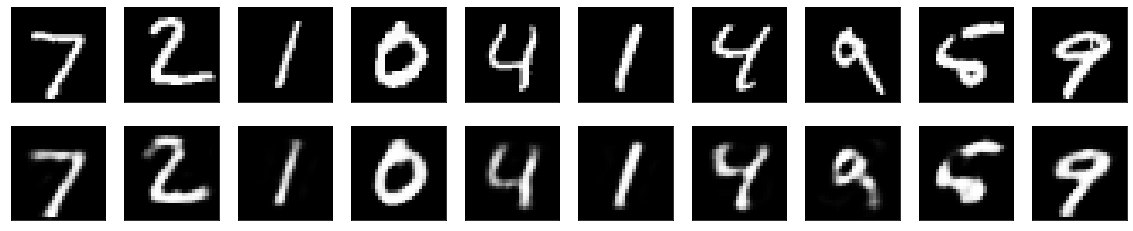

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
